## Test and visualize alignment method

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from ast import literal_eval

In [2]:
# torch
import torch
import torchvision
from torchvision import transforms as trafos

# addons
from tqdm import tqdm

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/matplotlib/__init__.py:907: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [4]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
relative_path = '../../'
# ensure that parent path is on the python path in order to have all packages available
import sys, os
parent_path = os.path.join(os.getcwd(), relative_path)
parent_path = os.path.realpath(parent_path)  # os.path.abspath(...)
sys.path.insert(0, parent_path)

In [6]:
from lib.models.trained_model_loader import get_line_net_fcn

from lib.datasets.segments_dataset import CuneiformSegments

from lib.transliteration.sign_labels import get_label_list

from lib.evaluations.config import cfg, cfg_from_file, cfg_from_list
from lib.evaluations.line_evaluation import LineAnnotations
from lib.evaluations.sign_evaluation_gt import BBoxAnnotations

from lib.utils.transform_utils import UnNormalize
from lib.utils.path_utils import clean_cdli, prepare_data_gen_folder_slim, make_folder

from lib.alignment.run_gen_alignments import gen_alignments

### Config Basics

In [7]:
# dataset config
collections = ['test', 'train', 'saa01', 'saa05', 'saa08', 'saa10', 'saa13', 'saa16']

collections = ['test']

In [8]:
# visual config
show_sign_alignments = True
show_line_matching = True

# storage config
generate_and_save = False

In [9]:
# sign detector and line segmentation network config
sign_model_version = 'v191ft01' 

line_model_version = 'v007' 

In [10]:
pre_config = ['TEST.TP_MIN_OVERLAP', 0.5, 'TEST.NMS', 0.5]

# ensure config is loaded before dependent functions are used/ instantiated
cfg_from_list(pre_config)

In [11]:
# load lbl list
lbl_list = get_label_list(relative_path + 'data/newLabels.json')

In [12]:
param_dict = {'angle_long_range': True,
              'lambda_angle': 2,
              'lambda_iou': 0.4, 
              'lambda_offset': 1,
              'lambda_p': 5,
              'lambda_score': 12.0,  
              'lr_lambda_angle': 0.2, 
              'lr_lambda_iou': 1.5,  
              'lr_sigma_angle': 0.1,
              'lr_sigma_iou': 0.05,
              'outlier_cost': 25, 
              'sigma_angle': 0.6,
              'sigma_iou': 0.4,
              'sigma_offset': 1,
              'sigma_p': 3,
              'sigma_score': 0.88, 
              'refined': True}

### Config Data Augmentation

In [13]:
num_classes = 2  # for line detection
num_c = 1
gray_mean = [0.5]
gray_std = [1.0]

In [14]:
re_transform = torchvision.transforms.Compose([
    UnNormalize(mean=gray_mean, std=gray_std),
    torchvision.transforms.ToPILImage(),
                                              ])
re_transform_rgb = torchvision.transforms.Compose([
    UnNormalize(mean=gray_mean * 3, std=gray_std * 3),
    torchvision.transforms.ToPILImage(),
                                              ])

### Load Model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
if 0:
    model_fcn = get_line_net_fcn(line_model_version, device, num_classes=num_classes, num_c=num_c)
    print(model_fcn)
else:
    model_fcn = None

### Generate alignments

  0%|          | 0/1 [00:00<?, ?it/s]

collection: <><>test<><>
Setup test dataset with 16 elements
Load bbox annotations for test dataset: 16 found!



test:   0%|          | 0/2 [00:00<?, ?it/s]

Load line annotations for test dataset: 15 found!
Transliteration file ../../data/transliterations/transliterations_test.csv found!
(2, 'K08396', 'Rev')
Load annotations: 175 gt bboxes found.
detected groups: 26 | num lines: 24.
Update: detected groups: 26 | num lines: 24.


/home/tobias/.virtualenvs/pytorch/local/lib/python2.7/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


LineHypos-TL assignment accuracy: 1.0
mAP 0.7337 | global AP: 0.7946 | mAP (align): 0.8542
total_tp: 140 | total_fp: 30 [34] | acc: 0.82


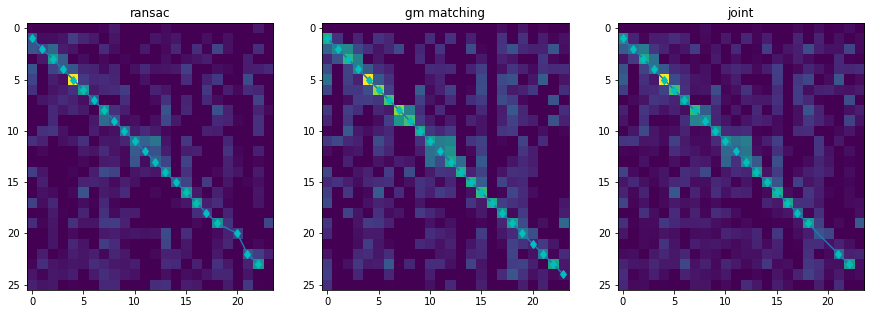

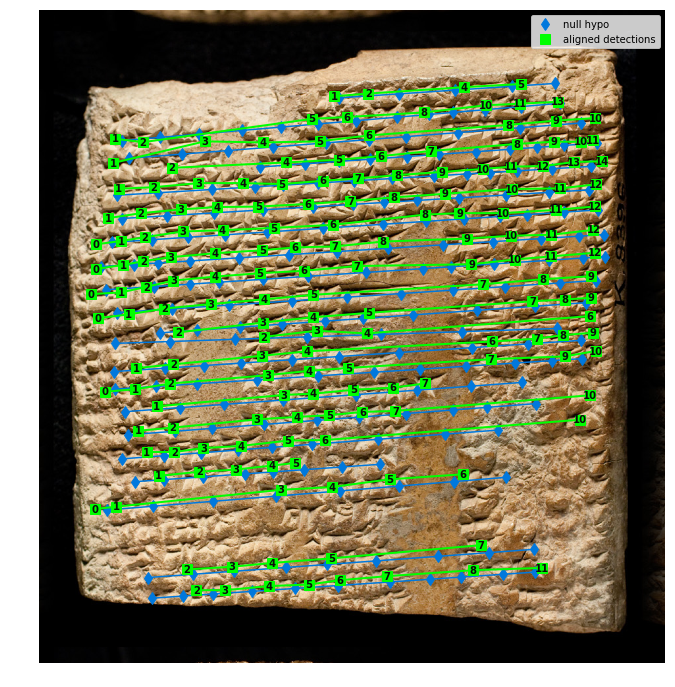


test:  50%|█████     | 1/2 [00:19<00:19, 19.28s/it]

(3, 'K08396', 'Obv')
Load annotations: 116 gt bboxes found.
detected groups: 22 | num lines: 22.
Update: detected groups: 22 | num lines: 22.
LineHypos-TL assignment accuracy: 1.0
mAP 0.9098 | global AP: 0.8855 | mAP (align): 0.9402
total_tp: 104 | total_fp: 15 [20] | acc: 0.87


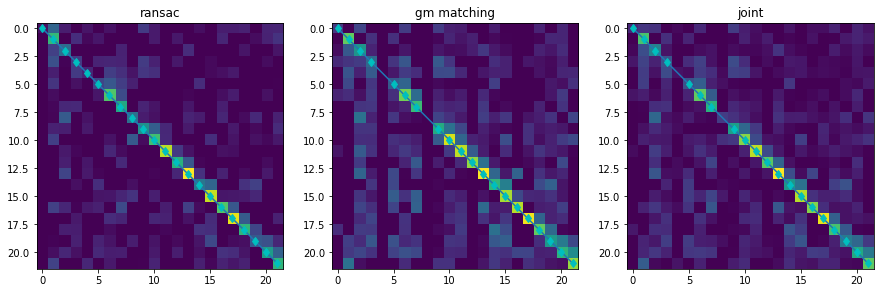

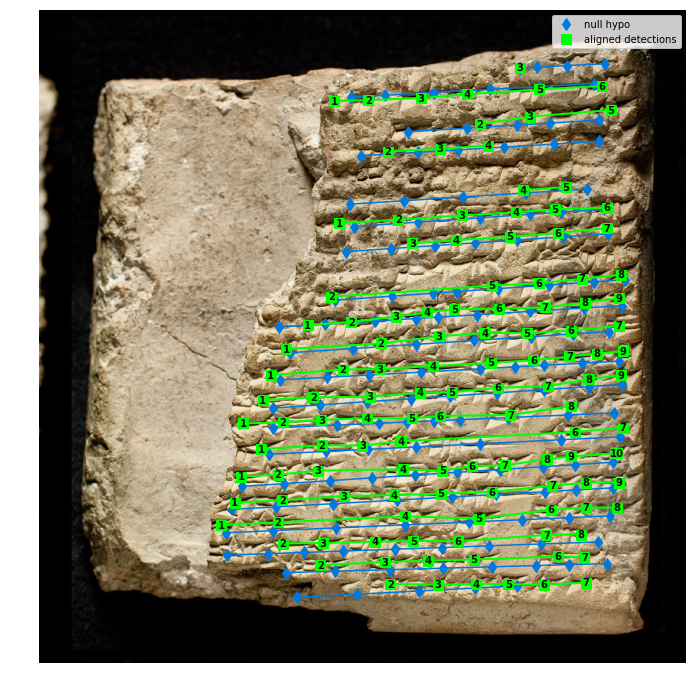


100%|██████████| 1/1 [00:34<00:00, 34.98s/it]

test | v191ft01
RESULTS ON FULL COLLECTION :
mAP 0.8266 | global AP: 0.831 | mAP (align): 0.8701
total_tp: 244 | total_fp: 51 [54] | prec: 0.827


In [17]:
for saa_version in tqdm(collections):
    print('collection: <><>{}<><>'.format(saa_version))
    
    ### Create folder
    # create path to file that stores generated training data
    res_path_base = '{}results/results_ssd/{}'.format(relative_path, sign_model_version)
    train_data_ext_file, collection_subfolder = prepare_data_gen_folder_slim(saa_version, res_path_base)
    
    ### Get collection dataset and annotations
    dataset = CuneiformSegments(transform=None, target_transform=None, relative_path=relative_path, collection=saa_version)
    
    # load annotations for collection
    bbox_anno = BBoxAnnotations(dataset.collection, relative_path=dataset.relative_path)
    lines_anno = LineAnnotations(dataset.collection, 
                                 coll_scales=dataset.assigned_segments_df.scale,
                                 relative_path=relative_path)

    # filter collection dataset - OPTIONAL
    didx_list = range(len(dataset))
    didx_list = didx_list[2:4]
    
    ### Generate line hypothesis
    gen_alignments(didx_list, dataset, bbox_anno, lines_anno, relative_path, saa_version, re_transform,
                   sign_model_version, model_fcn, device,
                   generate_and_save, show_sign_alignments, collection_subfolder, 
                   train_data_ext_file, lbl_list, use_precomp_lines=True,
                   param_dict=param_dict, show_line_matching=show_line_matching, verbose=True)